<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

### import and create df

In [2]:
path = "./data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv"

In [3]:
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.utils import lemmatize
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore
from spacy.lang.en import English
import pandas as pd

In [43]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [38]:
import warnings
warnings.filterwarnings('ignore')
#To silence sum(generator)

In [4]:
df = pd.read_csv(path)

### explore

In [5]:
df['brand'] = df['brand'].apply(str.lower)

In [6]:
df['brand'].value_counts()

amazon          16153
amazonbasics    12179
Name: brand, dtype: int64

In [7]:
df.head(1)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."


In [8]:
df.columns

Index(['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand',
       'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'reviews.date', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs'],
      dtype='object')

### Tokenize

In [9]:
def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [10]:
df['tokens'] = df['reviews.text'].apply(tokenize)

In [11]:
df['reviews.text'][0]

'I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put a pcs of aluminum to make the battery work.'

In [12]:
df['tokens'][0]

['order',
 'item',
 'bad',
 'quality',
 'missing',
 'backup',
 'spring',
 'pcs',
 'aluminum',
 'battery',
 'work']

### Create Dictionary

In [15]:
id2word = corpora.Dictionary(df['tokens'])

In [17]:
len(id2word.keys())

9622

In [18]:
id2word.filter_extremes(no_below=5, no_above=0.85)

In [19]:
len(id2word.keys())

3582

### Create corpus

In [20]:
corpus = [id2word.doc2bow(text) for text in df['tokens']]

In [24]:
len(corpus) #Check length

28332

In [25]:
df.shape  #Correct length

(28332, 25)

### Fit LDA

In [39]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 8,
                   passes=10,
                   workers=4
                  )

In [40]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [41]:
topics = [' '.join(t[0:5]) for t in words]

In [42]:
for id, t in enumerate(topics): 
    print(f'-----Topic {id} -----')
    print(f"{t}\n")

-----Topic 0 -----
great tablet easy use recommend

-----Topic 1 -----
tablet use apps amazon games

-----Topic 2 -----
kindle love read screen books

-----Topic 3 -----
good great price product batteries

-----Topic 4 -----
amazon device tablet price better

-----Topic 5 -----
loves old year tablet bought

-----Topic 6 -----
batteries long work amazon battery

-----Topic 7 -----
gift bought christmas best buy



### Check coherence

In [48]:
from gensim.models.coherencemodel import CoherenceModel

In [54]:
cm = CoherenceModel(model=lda, corpus=corpus, coherence='u_mass')

In [55]:
coherence = cm.get_coherence()  # get coherence value

In [56]:
coherence

-2.953735019317448

#### Refit function from lecture

In [57]:
def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [59]:
coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        start=2, 
                                                        limit=20, 
                                                        step=5,
                                                        passes=10)

In [60]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

In [61]:
topic_coherence.head()

,coherence_score,num_topics,pass
0,-2.591045,2,0
1,-2.610810,7,0
2,-2.750213,12,0
3,-2.732078,17,0
4,-2.591361,2,1


### Visuals

In [45]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.190418 -0.111818       1        1  22.234009
1     -0.122117  0.080947       2        1  14.922306
5     -0.186253  0.039546       3        1  14.249553
2     -0.089348 -0.030354       4        1  12.138127
3      0.295493  0.114516       5        1  10.419210
4      0.013933 -0.031961       6        1   9.577480
0     -0.052644  0.181844       7        1   9.210544
7     -0.049482 -0.242721       8        1   7.248768, topic_info=     Category         Freq       Term        Total  loglift  logprob
34    Default  5730.000000       good  5730.000000  30.0000  30.0000
18    Default  7155.000000  batteries  7155.000000  29.0000  29.0000
21    Default  9013.000000      great  9013.000000  28.0000  28.0000
17    Default  5078.000000      price  5078.000000  27.0000  27.0000
2076  Default  3022.000000     kindle  3022.000000  26.0000  26.0000
2433  Default  6795.000000     tablet  6795.000000  25.0000  25.0000
105   Default  1791.000000       year  1791.000000  24.0000  24.0000
521   Default  2180.000000        old  2180.000000  23.0000  23.0000
1857  Default  2239.000000      loves  2239.000000  22.0000  22.0000
755   Default  2945.000000       easy  2945.000000  21.0000  21.0000
165   Default  2050.000000    product  2050.000000  20.0000  20.0000
90    Default  3463.000000       love  3463.000000  19.0000  19.0000
94    Default  4441.000000        use  4441.000000  18.0000  18.0000
192   Default  2431.000000       kids  2431.000000  17.0000  17.0000
885   Default  1193.000000       gift  1193.000000  16.0000  16.0000
652   Default  1675.000000      games  1675.000000  15.0000  15.0000
387   Default  1010.000000      value  1010.000000  14.0000  14.0000
1548  Default  1773.000000       apps  1773.000000  13.0000  13.0000
28    Default  3277.000000     bought  3277.000000  12.0000  12.0000
23    Default  2424.000000       long  2424.000000  11.0000  11.0000
20    Default  1237.000000      brand  1237.000000  10.0000  10.0000
7     Default  1351.000000    quality  1351.000000   9.0000   9.0000
1679  Default  1661.000000     screen  1661.000000   8.0000   8.0000
31    Default   966.000000  christmas   966.000000   7.0000   7.0000
9     Default  2216.000000       work  2216.000000   6.0000   6.0000
432   Default   818.000000       deal   818.000000   5.0000   5.0000
786   Default  1190.000000       read  1190.000000   4.0000   4.0000
409   Default  1100.000000       play  1100.000000   3.0000   3.0000
96    Default  1506.000000      works  1506.000000   2.0000   2.0000
1268  Default   962.000000   daughter   962.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
788    Topic8    50.832981    charges    63.903278   2.3955  -6.0835
885    Topic8   572.280151       gift  1193.340210   1.8895  -3.6624
162    Topic8   110.140472      thank   165.141891   2.2193  -5.3103
157    Topic8   137.958038       gave   219.691223   2.1591  -5.0851
694    Topic8    81.917282     return   121.890778   2.2269  -5.6063
31     Topic8   393.879486  christmas   966.134766   1.7271  -4.0360
234    Topic8   227.567474        day   476.887451   1.8845  -4.5846
1020   Topic8   130.896820       went   248.139191   1.9848  -5.1376
181    Topic8   121.439491     thanks   228.193024   1.9936  -5.2126
880    Topic8   108.848030       help   195.728851   2.0376  -5.3221
960    Topic8   136.661819        mom   293.084229   1.8614  -5.0945
222    Topic8   378.718262       best  1429.573364   1.2960  -4.0752
3      Topic8   166.262863       item   410.752075   1.7199  -4.8984
901    Topic8   155.701965      loved   432.944977   1.6017  -4.9641
115    Topic8   157.093842       know   441.537811   1.5909  -4.9552
217    Topic8   175.682968     charge   569.699524   1.4479  -4.8433
28     Topic8   446.876831     bought  3277.936523   0.6317  -3.9097
173    Topic8   313.670624       tim

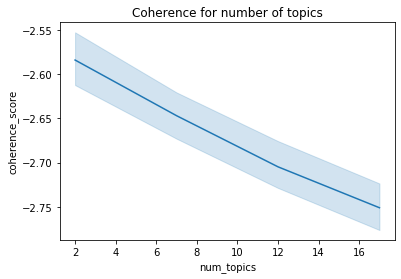

In [72]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)
ax.set_title("Coherence for number of topics");

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling

In [78]:
topic_coherence

,coherence_score,num_topics,pass
0,-2.591045,2,0
1,-2.610810,7,0
2,-2.750213,12,0
3,-2.732078,17,0
4,-2.591361,2,1
5,-2.694664,7,1
6,-2.681667,12,1
7,-2.820335,17,1
8,-2.507879,2,2
9,-2.664864,7,2
